# Amazon Reviews Sentiment Analysis

Data შეიცავს 3 600 000 მონაცემს. რივიუების უდიდესი რაოდენობა არის ინგლისური. ასევე ვხვდებით ესპანურ რივიუებსაც მაგრამ აღსანიშნავია, რომ არაინგლისურენოვანი რივიუები იმდენად ცოტაა მთლიან რაოდენობასთან შედარებით (10000) შეგვიძლია ტრინინგის დროს საერთოდ დავაიგნოროთ. 

ამ შემთხვევაში, multilingual მოდელს თუ არ ვიყენებთ, მაგალითად mBERT-ს, ტესტში მყოფი არაინგლისური რივიუები სართოდ უცხო იქნება მოდელისთვის. მარტო იმის გამო, რომ უცხოურ რივიუებსაც ვხვდებით, მხოლოდ mBERT-ის გამოყენება ძალიან ცუდი აზრია, რადგან ის შედარებით ცუდ შედეგს დადებს ინგლისურზეც, თუნდაც ვიდრე სხვა BERT like მოდელები. 
ამ პრობლემის გადასაჭრელად, გადავწყვიტე გამომეყენებინა translator. როგორც აღვნიშნე, მოდელის დატრენინგების დროს არაინგლისურენვან რივიუებს გადავყრი, მაგრამ ტესტში შემხვედრ რივიუს ინგლისურში ვთარგმნი და შემდეგ გავაკეთებ მასზე ფრედიქშენს.

ზემოთ ვახსენე ბერტი, მაგრამ სენტიმენტ ანალიზისთვის არცთუ ისე ცუდი შედეგი აქვთ სხვა მოდელებსაც, რომლებიც არ იყენებენ ტრანსფორმერს. ამ კონკრეტულ დეითაში მონაცემები პირდაპირ გამზადებული არის იმისთვის, რომ დამუშავდეს და fasttext-ზე გაეშვას.ამიტომ, სანამ უფრო რთულ მოდელებს გავწვრთნი, პირველ რიგში მინდა ვცადო word2vec-ის extension fasttext და ვნახო შედეგი. მონაცემების რაოდენობა საკმაოდ დიდია და მათი კარგი გაწმენდის შედეგად საინტერესოა შედეგი, რომელსაც ის დადებს

იმისთვის, რომ მოდელი სენტიმენტ ანალიზისთვის დავატრენინგოთ და კარგ შედეგზე გავიდეთ, აუცილებელია დეითას კარგად გაწმენდა

In [5]:
import pandas
import numpy
import gcld3
from pycountry import languages
import transformers
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
import translators as ts
from autocorrect import Speller
import re
import fasttext
import pandas as pd

Using Georgia server backend.


In [2]:
# returns text's language
# speed or FastText would be better

def detect_language(text):
    detector = gcld3.NNetLanguageIdentifier(min_num_bytes=0, 
                                        max_num_bytes=100000)
    result = detector.FindLanguage(text=text)
    if languages.get(alpha_2=result.language) == None:
        return None
    return languages.get(alpha_2=result.language).name

In [3]:
## translates to English

def translate(text):
    return ts.google(text, if_use_cn_host=True)

In [4]:
## removes urls

def remove_url(text):
    text = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', 
                   text, flags=re.MULTILINE)  # to remove links that start with HTTP/HTTPS in the tweet
    text = re.sub(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', 
                   text, flags=re.MULTILINE) # to remove other url links
    return text

In [5]:
## removes emoji

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [6]:
## removes numbers and punctuations

def remove_nums_punctuations(text): 
    punctuations = '''!()-![]{};:+'"\,<>./?@#$%^&*_~'''
    nums = '0123456789'
    return ''.join([i for i in text if i not in punctuations and i not in nums])

In [7]:
## converting apostrophe/short words in the better form

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
## removes extra white spaces

def remove_extra_whitespaces(text):
    return re.sub(' {2,}', ' ', text)

In [9]:
## removes specific stop words

def remove_stop_words(text):
    stop_words=['in','of','at','a','the, i, them, you, their, myself, our, ours, me, he, him, it, ours']
    tokens = text.split(' ')
    return ' '.join([word for word in tokens if word not in stop_words])

In [10]:
## spell checker

def spell_check(text):
    spell = Speller('en')
    s = ' '.join([spell(w) for w in text.split(' ')])
    return s

In [28]:
## removes duplicated chars. happyyyyyy -> hapy -> spell checker -> happy

def remove_duplicates(text):
    return re.compile(r'(.)\1{1,}', re.IGNORECASE).sub(r'\1', text)

In [11]:
## preprocessing

def preprocess(text):
    text = text.lower()
    text = remove_extra_whitespaces(text)
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_nums_punctuations(text)
    text = remove_duplicates(text)
    text = spell_check(text)
    text = decontracted(text)
    text = remove_stop_words(text)
    return text

In [2]:
TRAIN_PATH = '/Users/test/Downloads/archive/train.ft.txt'
TEST_PATH = '/Users/test/Downloads/archive/test.ft.txt'
NEW_TRAIN_PATH = '/Users/test/Downloads/archive/new_train.ft.txt'
NEW_TEST_PATH = '/Users/test/Downloads/archive/new_test.ft.txt'

In [13]:
train_txt = open(TRAIN_PATH, "r")
new_train_txt = open(NEW_TRAIN_PATH, "w")
p = 0.0
cnt = 0.0
for line in train_txt:
    if detect_language(line[10:]) == 'English':
        preprocessed = line[:10] + preprocess(line[10:])
        new_train_txt.write(preprocessed)
    if cnt == 36000:
        break
    if cnt == 360*p:
        print(str(p) + '%')
        p+=1
    cnt+=1
train_txt.close()
new_train_txt.close()

0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%


In [16]:
test_txt = open(TEST_PATH, "r")
new_test_txt = open(NEW_TEST_PATH, "w")
cnt = 0
for line in test_txt:
    if cnt == 5000:
        break
    cnt += 1
    review = line[10:]
    language = detect_language(review)
    if language == None:
        continue
    if language != 'English':
        review = translate(review)
    preprocessed = line[:10] + preprocess(review)
    new_test_txt.write(preprocessed)
test_txt.close()
new_test_txt.close()

In [17]:
model = fasttext.train_supervised(NEW_TRAIN_PATH, wordNgrams=2)

In [18]:
def print_results(sample_size, precision, recall):
    precision   = round(precision, 2)
    recall      = round(recall, 2)
    print(f'{sample_size=}')
    print(f'{precision=}')
    print(f'{recall=}')

print_results(*model.test(NEW_TEST_PATH))

sample_size=4958
precision=0.9
recall=0.9


In [46]:
def get_prediction(model, text):
    tp = model.predict(text)
    if tp[0][0] == '__label__2':
        return 'Positive'
    else:
        return 'Negative'

In [57]:
text = 'Quality was bad but i really enjoyed this app and cd. It was good for it\'s price.'
text = preprocess(text)
print(text)
get_prediction(model,text)

quality was too bad i really enjoyed this app and cd it was good for its price


'Positive'

END

In [3]:
labels = []
reviews = []

test_labels = []
test_reviews = []

cnt1 = 0 
p1 = 0 
cnt2 = 0
p2 = 0
train_txt = open(NEW_TRAIN_PATH, 'r')
for line in train_txt:
    label = line[:10]
    review = line[10:]
    labels.append(label)
    reviews.append(review)
train_txt.close()

test_txt = open(NEW_TEST_PATH, 'r')
for line in test_txt:
    label = line[:10]
    review = line[10:]
    test_labels.append(label)
    test_reviews.append(review)
test_txt.close()

In [6]:
df = pd.DataFrame({'labels' : labels, 'reviews': reviews})
df.head(5)

,labels,reviews
0,__label__2,tuning even for the nongamer this sound track...
1,__label__2,the best soundtrack ever to anything im readi...
2,__label__2,amazing this soundtrack is my favorite music ...
3,__label__2,excellent soundtrack i truly like this soundt...
4,__label__2,remember pull your jaw off the floor after he...


In [7]:
def fun(x):
    if x == '__label__2':
        return 1
    else:
        return 0

In [8]:
df.labels = df.labels.apply(fun)

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, Bidirectional

In [23]:
max_f = 300
tokenizer = Tokenizer(num_words=max_f, split=' ')
tokenizer.fit_on_texts(df['reviews'].values)
x = tokenizer.texts_to_sequences(df['reviews'].values)
X = pad_sequences(x)

In [26]:
embed_dim = 128
lstm_out = 128

model = Sequential()
model.add(Embedding(max_f, embed_dim, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 187, 128)          256000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 187, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 519,682
Trainable params: 519,682
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
test_df = pd.DataFrame({'labels': test_labels, 'reviews': test_reviews})
Le = LabelEncoder()
y = Le.fit_transform(df['labels'])
X_train = X
y_train = y
y_train = y_train - 1
y_train = to_categorical(y_train, 2)

max_f = 2000
tokenizer = Tokenizer(num_words=max_f, split=' ')
tokenizer.fit_on_texts(test_df['reviews'].values)
xx = tokenizer.texts_to_sequences(test_df['reviews'].values)
X_test = pad_sequences(xx)
y_test = Le.fit_transform(test_df['labels'])
y_test = y_test - 1
y_test = to_categorical(y_test, 2)

In [28]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=5, batch_size=512)

Epoch 1/5
71/71 [==============================] - 305s 4s/step - loss: 0.5912 - accuracy: 0.6958 - val_loss: 0.7573 - val_accuracy: 0.5701
Epoch 2/5
71/71 [==============================] - 282s 4s/step - loss: 0.3367 - accuracy: 0.8567 - val_loss: 0.9417 - val_accuracy: 0.5313
Epoch 3/5
71/71 [==============================] - 282s 4s/step - loss: 0.2713 - accuracy: 0.8910 - val_loss: 1.1568 - val_accuracy: 0.5301
Epoch 4/5
71/71 [==============================] - 282s 4s/step - loss: 0.2515 - accuracy: 0.8991 - val_loss: 1.0491 - val_accuracy: 0.5337
Epoch 5/5
71/71 [==============================] - 326s 5s/step - loss: 0.2400 - accuracy: 0.9032 - val_loss: 0.9833 - val_accuracy: 0.5311


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


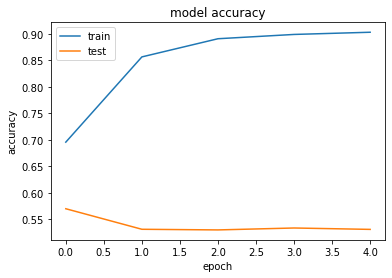

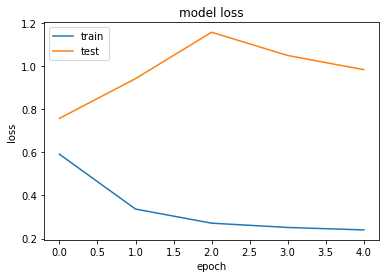

In [29]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()